In [1]:
!pip install CoolProp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI

     |████████████████████████████████| 4.0MB 2.7MB/s 


# Input Data

Input the initial temperature and the dimensions of the pool

In [0]:
T_now_C = 11.07
T_now = T_now_C + 273.15
A = 40
H = 1.5

V = A*H
m = PropsSI('D','P',101325,'T',T_now,'Water')*V

# Control Variables


## Description

- Changing `heater = 1` will activate external heating
- Changing `convection = 1` will activate heat loss through convection
- Changing `evaporation = 1` will activate heat loss through evaporation
- Changing `solar = 1` will activate solar panel aided heating
    - Changing `control = 0` will close the solar heating feed valve
    - Changing `control = 0.5` will activate sensor which will restrict heating to user defined temperature, will take value from external heating control
    - Changing `control = 1` will open the solar heating feed valve permanently

In [0]:
heater = 1          #1
convection = 1      #2
evaporation = 1     #3
solar = 0           #4
control = 1         #5
eff = 0.2           #6
ctrend = 0          #7
etrend = 0          #8
hVal = 2            #9
eVal = 10           #10

### Executing Cases

1. Solar panel off, evaporation and convection off
2. Solar panel off, evaporation and convection on at recommmended values
3. Solar panel on at 100% efficiency, evaporation and convection on at recommended values
4. Solar panel on at 100% efficiency, evaporation and convection on at recommended values, control valve on
5. Solar panel off, evaporation and convection on at average values
6. Solar panel on at 20% efficiency, evaporation and convection on at average values
7. Solar panel off, evaporation and convection on at correlated values
8. Solar panel on at 20% efficiency, evaporation and convection on at correlated values


1. [1, 0, 0, 0,   1,   1, 0, 0,  2,  1]
2. [1, 1, 1, 0,   1,   1, 0, 0,  2,  1]
3. [1, 1, 1, 1,   1,   1, 0, 0,  2,  1]
4. [1, 1, 1, 1, 0.5,   1, 0, 0,  2,  1]
5. [1, 1, 1, 0,   1, 0.2, 0, 0, 20, 10]
6. [1, 1, 1, 1,   1, 0.2, 0, 0, 20, 10]
7. [1, 1, 1, 0,   1, 0.2, 1, 1,  2,  1]
8. [1, 1, 1, 1,   1, 0.2, 1, 1,  2,  1]

## External Heating Control

External heating to user-defined temperature

In [0]:
T_user_C = 18
T_user = T_user_C + 273.15
Q_H = 0

## Convection Control

Heat loss through convection, heat transfer coefficient taken from linear interpolation of wind data

In [0]:
Q_C = 0

def h_conv(w):
    if ctrend==1:
      y = 10 + (30)*(w-1)/(9)
      return y
    else:
      return hVal

## Evaporation Control

Heat and mass loss through evaporation with predefined mass loss per day

In [0]:
q_ev = PropsSI('H','P',101325,'Q',1,'Water') - PropsSI('H','P',101325,'Q',0,'Water')

def ev1(w,T):
  if etrend==1:
    y = 4 + (16-4)*(w)/(3)
    D = PropsSI('D','P',101325,'T',T,'Water')
    return 0.1*y/D
  else:
    return eVal*1e-3/24

Q_E = 0

## Solar Panel Control

Solar panel heating with efficiency and area of panel as input

In [0]:
a = 10
Q_S = 0

# KNMI Weather Data

Temperature, sunshine and wind data from April 1st, 2019 to April 30th, 2019

In [0]:
url = 'https://raw.githubusercontent.com/shyam97/modelling1/master/knmi.csv'
array = pd.read_csv(url, sep=',',header=None)
temp = 0.1*array.values[:,0]
shine = 1e4*array.values[:,1]
wind = 0.1*array.values[:,2]
hours = np.linspace(1,31,num=len(temp))

## Plot of Local Temperature

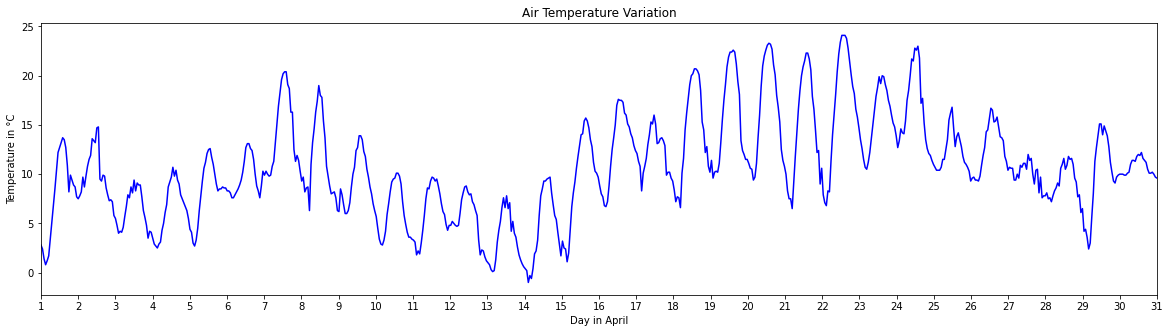

In [9]:
plt.figure(figsize=(20,5))
plt.plot(hours,temp,'b')
plt.xlim([1,30])
plt.xlabel("Day in April")
plt.ylabel("Temperature in °C")
plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
plt.title("Air Temperature Variation")
plt.show()

## Plot of Sunshine

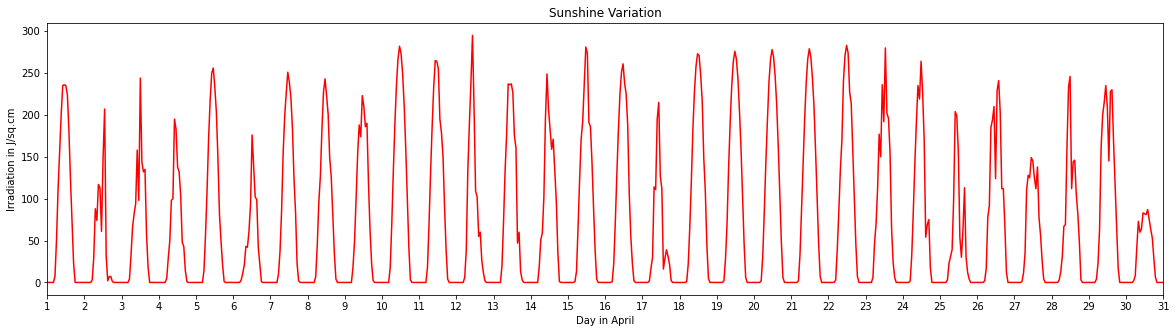

In [10]:
plt.figure(figsize=(20,5))
plt.plot(hours,1e-4*shine,'r')
plt.xlim([1,30])
plt.xlabel("Day in April")
plt.ylabel("Irradiation in J/sq.cm")
plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
plt.title("Sunshine Variation")
plt.show()

## Plot of Wind Speed

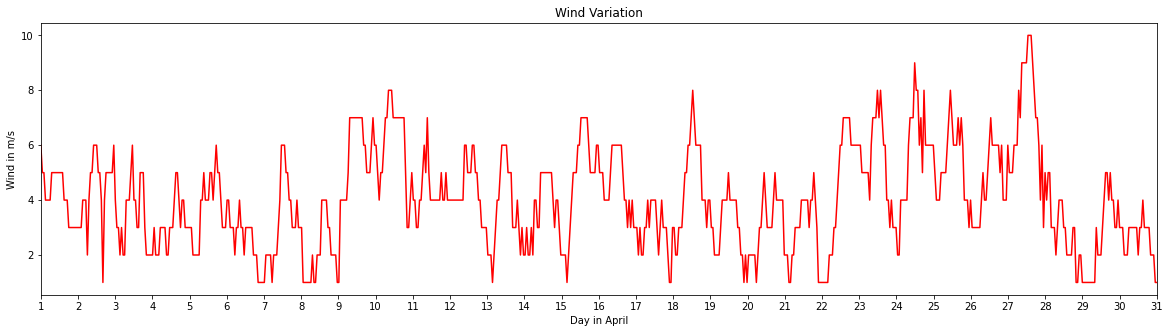

In [11]:
plt.figure(figsize=(20,5))
plt.plot(hours,wind,'r')
plt.xlim([1,30])
plt.xlabel("Day in April")
plt.ylabel("Wind in m/s")
plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
plt.title("Wind Variation")
plt.show()

# Without External Heating

In [0]:
T = np.zeros((len(temp)+1,1))
Q_CM = np.zeros((len(temp),1))
Q_EM = np.zeros((len(temp),1))
Q_SM = np.zeros((len(temp),1))
Q_M = np.zeros((len(temp),1))
m_M = np.zeros((len(temp)+1,1))
T[0] = T_now
m_M[0] = m

for i in range(0,len(temp)):
    if T_now < 273.15:
        print("The pool froze!")
        m_M = m_M[0:i]
        T = T[0:i]
        Q_M = Q_M[0:i]
        Q_CM = Q_CM[0:i]
        Q_EM = Q_EM[0:i]
        Q_SM = Q_SM[0:i]
        break
    D = PropsSI('D','P',101325,'T',T_now,'Water')  
    Cp = PropsSI('Cpmass','P',101325,'T',T_now,'Water')
    
    if convection==1:
        h_c = h_conv(wind[i])
        Q_C = - h_c * A * (T_now - temp[i] - 273.15)
        Q_CM[i] = Q_C
    
    if evaporation==1:
        V_ev = ev1(wind[i],T_now)
        m1 = m
        m2 = m - D*V_ev
        m3 = 0.5*(m2+m1)
        m = m - V_ev*D
        Q_E = -q_ev*ev1(wind[i],T_now)*D
        Q_EM[i] = Q_E
    else:
        m3 = m
        
    if solar==1:
        if control ==1:
            Q_S = shine[i]*eff*a
        elif control==0.5:
            if T_now<T_user:
                Q_S = shine[i]*eff*a
            else:
                Q_S = 0
        else:
            Q_S = 0
        Q_SM[i] = Q_S
        
    Q = Q_S + Q_E + Q_C
    Q_M[i] = Q
    
    delT = Q/(m3*Cp)
    T_next = T_now + delT
    T[i+1] = T_next
    T_now = T_next
    m_M[i+1] = m

## Plot of Temperature of Pool Water

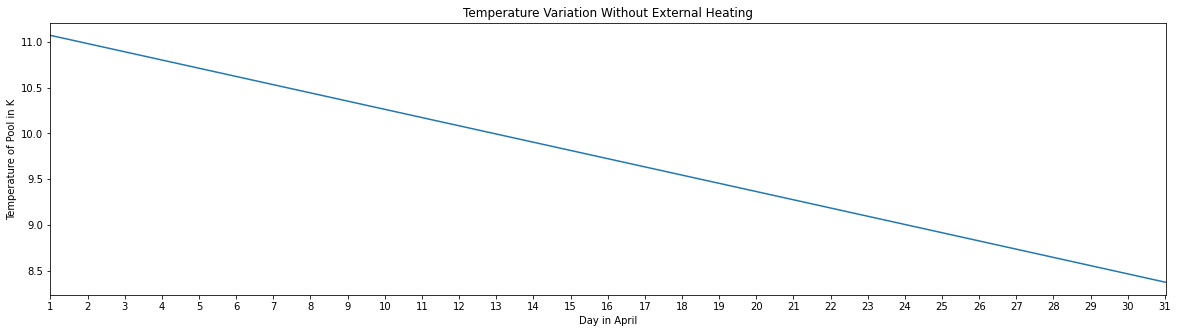

In [13]:
if convection or evaporation or solar:
    hour = np.linspace(1,len(T)/24+1,num=len(T))
    plt.figure(figsize=(20,5))
    plt.plot(hour,T-273.15)
#     plt.plot(hours,temp)
    plt.xlim([1,len(T)/24+1])
    plt.xlabel("Day in April")
    plt.ylabel("Temperature of Pool in K")
    plt.xticks(np.arange(min(hour), max(hour), 1.0))
    plt.title("Temperature Variation Without External Heating")
    plt.show()

## Plot of Heat Flux

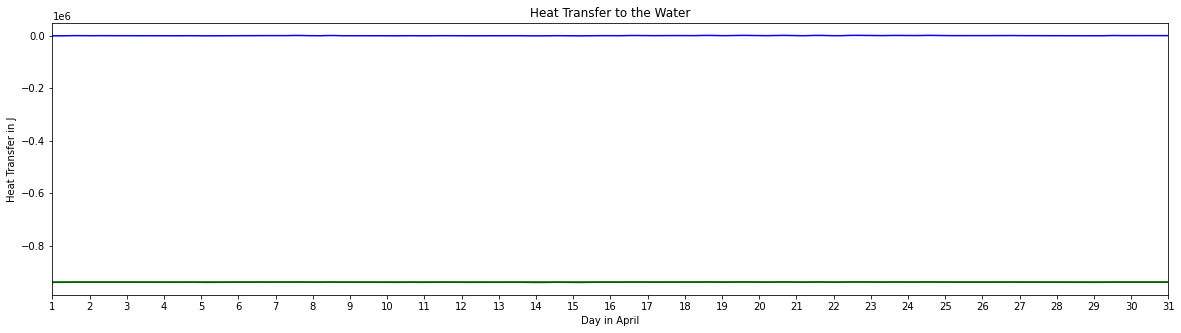

In [14]:
if convection or evaporation or solar:
    hours = np.linspace(1,len(Q_M)/24 + 1,num=len(Q_M))
    plt.figure(figsize=(20,5))
    plt.plot(hours,Q_M,'k')
    if convection==1:
        plt.plot(hours,Q_CM,'b')
    if evaporation==1:
        plt.plot(hours,Q_EM,'g')
    if solar==1:
        plt.plot(hours,Q_SM,'r')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(6,6))
    plt.xticks(np.arange(min(hours), max(hours)+1, 1.0))
    plt.xlim([1,len(Q_M)/24 + 1])
    plt.xlabel("Day in April")
    plt.ylabel("Heat Transfer in J")
    plt.title("Heat Transfer to the Water")
    plt.show()
    

## Plot of Mass of Pool Water

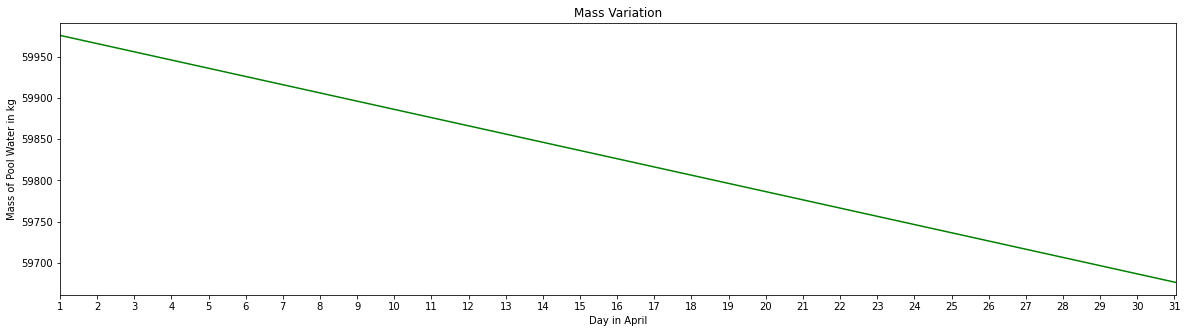

In [15]:
if convection or evaporation or solar:
    hours = np.linspace(1,len(m_M)/24 + 1,num=len(m_M))
    plt.figure(figsize=(20,5))
    plt.plot(hours,m_M,'g')
#     plt.plot(hours,temp)
    plt.xlim([1,len(m_M)/24+1])
    plt.xlabel("Day in April")
    plt.ylabel("Mass of Pool Water in kg")
    plt.xticks(np.arange(min(hours), max(hours), 1.0))
    plt.title("Mass Variation")
    plt.show()

# With External Heating

Heater must run at 950W capacity to reach 18.00°C. Operation will cost 171.00EUR.


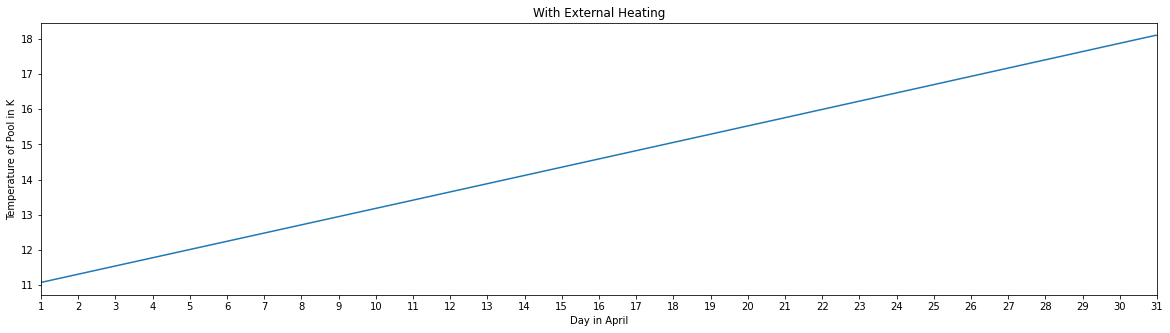

In [16]:
if heater==1:
    Q_H = 0
    if T_now > T_user:
        print("No heater required.")
    else:
        while(T_now < T_user):
            T_now = T_now_C + 273.15
            V = A*H
            T = np.zeros((len(temp)+1,1))
            T[0] = T_now
            m = m_M[0]
            
            for i in range(0,len(temp)):
                if T_now < 273.15:
                    break
                D = PropsSI('D','P',101325,'T',T_now,'Water')  
                Cp = PropsSI('Cpmass','P',101325,'T',T_now,'Water')
                
                if convection==1:
                    h_c = h_conv(wind[i])
                    Q_C = - h_c * A * (T_now - temp[i] - 273.15)
                
                if evaporation==1:
                    V_ev = ev1(wind[i],T_now)
                    m1 = m
                    m2 = m - D*V_ev
                    m3 = 0.5*(m2+m1)
                    m = m - V_ev*D
                    Q_E = -q_ev*ev1(wind[i],T_now)*D
                else:
                    m3 = m
                    
                if solar==1:
                    if control ==1:
                        Q_S = shine[i]*eff*a
                    elif control==0.5:
                        if T_now<T_user:
                            Q_S = shine[i]*eff*a
                        else:
                            Q_S = 0
                    else:
                        Q_S = 0
                    
                Q = Q_S + Q_E + Q_C + Q_H*3600
                
                delT = Q/(m3*Cp)
                T_next = T_now + delT
                T[i+1] = T_next
                T_now = T_next
                T[i] = T_now
                    
            Q_H = Q_H + 10
        
        units = Q_H*24*30/1000
        price = units*0.25
        print("Heater must run at %dW capacity to reach %.2f°C. Operation will cost %.2fEUR." %(Q_H,T_user-273.15,price))
        
    hour = np.linspace(1,31,num=len(T))
    plt.figure(figsize=(20,5))
    plt.plot(hour,T-273.15)
    # plt.plot(hours,temp+273.15)
    plt.xlim([1,30])
    plt.xlabel("Day in April")
    plt.ylabel("Temperature of Pool in K")
    plt.xticks(np.arange(min(hour), max(hour)+1, 1.0))
    plt.title("With External Heating")
    plt.show()

In [0]:
import csv
import os.path

if os.path.exists('data.csv'):  count = 0
else: count = 1

with open('data.csv', 'a+', newline='') as file:
    writer = csv.writer(file)
    if count == 1:
      writer.writerow(["Solar", "Evaporation", "Convection","Control","E-trend","C-trend","Efficiency","Power","Price"])
    writer.writerow([solar, evaporation, convection, control, etrend, ctrend, eff, Q_H, price])